In [2]:
import numpy as np
import pandas as pd
from google.cloud import bigquery, storage
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, t
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import math
import statsmodels.api as sm
from typing import Union
import logging
import sys
from google.cloud.exceptions import NotFound
import time
import os
import json
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google.auth import default
from typing import Union
from datetime import date, timedelta, datetime
from tqdm.auto import tqdm
import fastparquet as fp
import io


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ],
    force=True
)


# ------------------------------------------------------------------------------
# Data Queries
# ------------------------------------------------------------------------------

def get_marketing_data(entities, week):
    
    mkt_data = f"""

    WITH holdout_entities AS (
    SELECT
            entity_id,
            `Release Date` AS release_date
    FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
    WHERE `Release Date` < '{week}'
    AND entity_id in {entities}
    ),
    orders as (
    SELECT
         dps.entity_id entity_id
        ,dps.dps_customer_id customer_id
        ,COUNT(case when mkt.order_date <= e.release_date then mkt.order_id end) AS orders_pre
        ,COUNT(case when mkt.order_date > e.release_date then mkt.order_id end) AS orders_post
        ,SUM(case when mkt.order_date <= e.release_date then mkt.analytical_profit end) AS analytical_profit_pre
        ,SUM(case when mkt.order_date > e.release_date then mkt.analytical_profit end) AS analytical_profit_post
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
    JOIN holdout_entities AS e
        ON dps.entity_id = e.entity_id
    left join fulfillment-dwh-production.curated_data_shared_mkt.bima_order_profitability mkt
        ON mkt.global_entity_id = dps.entity_id
        AND mkt.order_id = dps.platform_order_code
        AND order_date >= DATE_SUB(release_date, INTERVAL 8 WEEK)
        AND order_date < '{week}'
        AND global_entity_id in {entities}
    WHERE dps.created_date >= DATE_SUB(e.release_date, INTERVAL 8 WEEK) 
        AND dps.created_date < '{week}'
        AND dps.platform_order_code IS NOT NULL
        AND dps.is_own_delivery
        AND dps.is_sent
        AND vendor_vertical_parent IN ('Restaurant','restaurant','restaurants')
        AND dps.entity_id in {entities}
    GROUP BY 1, 2
    ), 
    customer_information AS (
    SELECT
            e.entity_id,
            e.release_date,
            CASE WHEN d.created_date <= e.release_date THEN FALSE ELSE COALESCE(is_customer_holdout, FALSE) END AS is_customer_holdout,
            d.customer_id
    FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
    JOIN holdout_entities AS e
            ON d.entity_id = e.entity_id
    LEFT JOIN `fulfillment-dwh-production.cl._bad_dps_logs_ids` bad_ids
        ON d.customer_id = bad_ids.id
    WHERE d.created_date >= '2025-01-01' 
        AND d.created_date < '{week}'
        AND d.customer_id IS NOT NULL
        AND bad_ids.id IS NULL
        AND d.entity_id in {entities}
    GROUP BY 1, 2, 3, 4
    )
    SELECT 
            e.entity_id,
            e.customer_id,
            e.is_customer_holdout,
            o.orders_pre,
            o.orders_post,
            o.analytical_profit_pre,
            o.analytical_profit_post
    FROM customer_information e
    LEFT JOIN orders o
        ON o.customer_id = e.customer_id
        AND o.entity_id = e.entity_id

    """

    return mkt_data

def get_dps_data(entities, week):

    dps_data = f"""

    WITH holdout_entities AS (
    SELECT
            entity_id,
            `Release Date` AS release_date
    FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
    WHERE `Release Date` < '{week}'
    AND entity_id not in {entities}
    ),
    orders as (
    SELECT
        dps.entity_id entity_id
        ,dps.dps_customer_id customer_id
        ,COUNT(case when dps.created_date <= e.release_date then dps.platform_order_code end) AS orders_pre
        ,COUNT(case when dps.created_date > e.release_date then dps.platform_order_code end) AS orders_post
        ,SUM(case when dps.created_date <= e.release_date then dps.fully_loaded_gross_profit_eur end) AS analytical_profit_pre
        ,SUM(case when dps.created_date > e.release_date then dps.fully_loaded_gross_profit_eur end) AS analytical_profit_post
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
    JOIN holdout_entities AS e
        ON dps.entity_id = e.entity_id
    WHERE dps.created_date >= DATE_SUB(e.release_date, INTERVAL 8 WEEK) 
        AND dps.created_date < '{week}'
        AND dps.platform_order_code IS NOT NULL
        AND dps.is_own_delivery
        AND dps.is_sent
        AND vendor_vertical_parent IN ('Restaurant','restaurant','restaurants')
        AND dps.entity_id not in {entities}
    GROUP BY 1, 2
    ), 
    customer_information AS (
    SELECT
            e.entity_id,
            e.release_date,
            CASE WHEN d.created_date <= e.release_date THEN FALSE ELSE COALESCE(is_customer_holdout, FALSE) END AS is_customer_holdout,
            d.customer_id
    FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
    JOIN holdout_entities AS e
            ON d.entity_id = e.entity_id
    LEFT JOIN `fulfillment-dwh-production.cl._bad_dps_logs_ids` bad_ids
        ON d.customer_id = bad_ids.id
    WHERE d.created_date BETWEEN '2025-01-01' AND '{week}'
        AND d.customer_id IS NOT NULL
        AND bad_ids.id IS NULL
    GROUP BY 1, 2, 3, 4
    )
    SELECT 
    e.entity_id,
    e.customer_id,
    e.is_customer_holdout,
    o.orders_pre,
    o.orders_post,
    o.analytical_profit_pre,
    o.analytical_profit_post
    FROM customer_information e
    LEFT JOIN orders o
    ON o.customer_id = e.customer_id
    AND o.entity_id = e.entity_id

    """

    return dps_data


def get_brands():

    brand = """

    select DISTINCT
            p.entity_id,
            c.country_name,
            c.region,
            (CASE 
                WHEN p.brand_name = "Foodora" OR p.brand_name = "Foodpanda" OR p.brand_name = "Yemeksepeti" THEN "Pandora"
                WHEN p.brand_name = "eFood" OR p.brand_name = "Foody" THEN "GR/CY"
                WHEN p.brand_name = "PedidosYa" THEN "PEYA"
                WHEN p.brand_name = "Baemin" THEN "Woowa"
                WHEN p.brand_name = "FoodPanda" THEN "FP APAC"
                ELSE p.brand_name
                END) brand_name
    from `fulfillment-dwh-production.cl.countries` c
    left join unnest(c.platforms) p

    """

    return brand

# ------------------------------------------------------------------------------
# Data Extraction
# ------------------------------------------------------------------------------

def initialize_bigquery_client(project_id_pass):
   
    project_id = project_id_pass 

    logging.info(f"Initializing BigQuery client for project: {project_id}")

    if os.getenv("GITHUB_ACTIONS"):
        credentials_path = "/tmp/credentials.json" 
    else:
        credentials, project = default()  
        project_id = project if project else project_id 

    if os.getenv("GITHUB_ACTIONS") and not os.path.exists(credentials_path):
        raise FileNotFoundError(f"Credentials file not found at {credentials_path}. Make sure to set up authentication in GitHub Actions.")

    if os.getenv("GITHUB_ACTIONS"):
        with open(credentials_path, "r") as f:
            creds_data = json.load(f)

        credentials = Credentials.from_authorized_user_info(creds_data)

        if credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())

    try:
        client = bigquery.Client(credentials=credentials, project=project_id)
        logging.info(f"BigQuery client initialized successfully for project: {project_id}")
        return client 
    except Exception as e:
        logging.error(f"Failed to initialize BigQuery client: {e}")
        raise e


def get_iso_week_mondays(year, min_date=None, max_date=None):
    d = date(year, 1, 4)
    d -= timedelta(days=d.weekday())  # Get Monday of ISO week 1

    mondays = []
    while d.year <= year or (d.year == year + 1 and d.isocalendar()[1] == 1):
        if (
            d.isocalendar()[0] == year and
            (min_date is None or d > min_date) and
            (max_date is None or d <= max_date)
        ):
            mondays.append(d)
        d += timedelta(weeks=1)

    return mondays

def combined_data(client, mkt, dps):
    
    try:
        mkt_df = client.query(mkt).to_dataframe()
    except Exception as e:
        logging.error(f"Error executing marketing data query: {e}")
        mkt_df = pd.DataFrame() 

    try:
        dps_df = client.query(dps).to_dataframe()
    except Exception as e:
        logging.error(f"Error executing DPS data query: {e}")
        dps_df = pd.DataFrame()

    combined = pd.concat([mkt_df, dps_df], ignore_index=True)

    return combined


def extract_data(client, mkt_data, dps_data):
    
    start_time = time.time()
    logging.info(f"start_time: {start_time:.2f}")

    combined_df = combined_data(client,mkt_data, dps_data)
    elapsed_time = time.time() - start_time
    logging.info(f"Time to extract and combine data from DB: {elapsed_time:.2f} seconds")
    
    return combined_df 


def get_cumm_data(project,entities, week):

    client = initialize_bigquery_client(project)
    
    final_df = pd.DataFrame()

    for w_no in tqdm(week, desc=f'{week} - Week No', position=1):

    #for w_no in week:
        
        print(f"Querying for week starting {w_no}")
        
        tmp = extract_data(client ,get_marketing_data(entities, w_no), get_dps_data(entities,w_no))

        # Add the as_of_date column
        tmp["as_of_date"] = w_no

        # Append to the final dataframe
        final_df = pd.concat([final_df, tmp], ignore_index=True)

    return final_df


# ------------------------------------------------------------------------------
# Data Clean Up
# ------------------------------------------------------------------------------

def fill_nans(df):

    df = df.fillna({
        'orders_pre': 0,
        'orders_post': 0,
        'analytical_profit_pre': 0,
        'analytical_profit_post': 0,
    })

    return df

def drop_users_with_no_data(df):

    mask1 = (
        (df['orders_pre'] == 0) &
        (df['orders_post'] == 0) &
        (df['analytical_profit_pre'] == 0) &
        (df['analytical_profit_post'] == 0)
    )

    mask2 = (
        (df['orders_pre'].isna()) &
        (df['orders_post'].isna()) &
        (df['analytical_profit_pre'].isna()) &
        (df['analytical_profit_post'].isna())
    ) 

    df = df[~(mask1 |   mask2)]
    
    return df

def apply_cleanup(df):

    #NaN's are converted to 0's where applicable
    data_cleaned = fill_nans(df) 
    
    #remove customers with no data in the pre and the post period
    raw_data_final = drop_users_with_no_data(data_cleaned)

    return raw_data_final

# ------------------------------------------------------------------------------
# Performing Statistical Analysis
# ------------------------------------------------------------------------------


## Confidence Intervals for separate groups ##

def bootstrap_single_group(
    df: pd.DataFrame,
    adjusted_metric: str,
    n_resamples: int = 1000,
    alpha: float = 0.05,
    seed: int = 42
) -> dict:
    
    # Drop NaNs for safety
    group = df[adjusted_metric].dropna().values

    if len(group) == 0:
        raise ValueError(f"No valid data found for metric: {adjusted_metric}")

    # If all values are the same, skip bootstrap
    if np.all(group == group[0]):
        mean_val = group[0]
        return {
            "mean": round(mean_val, 4),
            "ci": (round(mean_val, 4), round(mean_val, 4))
        }

    # Use scipy's bootstrap with percentile CI
    res = stats.bootstrap(
        (group,),
        statistic=np.mean,
        n_resamples=n_resamples,
        method='percentile',
        confidence_level=1 - alpha,
        random_state=seed
    )

    bootstrap_means = res.bootstrap_distribution
    ci = res.confidence_interval
    mean_val = np.mean(group)
    bootstrap_mean = np.mean(bootstrap_means)

    return {
        "mean": round(mean_val, 4),
        "ci": (round(ci.low, 4), round(ci.high, 4)),
        "bootstrap_mean": round(bootstrap_mean, 4),
        "bootstrap_means" : bootstrap_means
    }

def plot_bootstrap_single_distribution(boot_result: dict, alpha: float = 0.05):
    
    boot_means = boot_result["bootstrap_means"]
    mean_val = boot_result["mean"]
    ci_low, ci_high = boot_result["ci"]

    plt.figure(figsize=(10, 6))
    plt.hist(boot_means, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val}')
    plt.axvline(ci_low, color='green', linestyle='--', linewidth=2, label=f'{100*(1-alpha):.0f}% CI Low: {ci_low}')
    plt.axvline(ci_high, color='green', linestyle='--', linewidth=2, label=f'{100*(1-alpha):.0f}% CI High: {ci_high}')
    
    plt.title("Bootstrap Distribution of the Mean")
    plt.xlabel("Mean Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_bootstrap_comparison_single_group(
    result1: dict, label1: str,
    result2: dict, label2: str,
    alpha: float = 0.05
):
    plt.figure(figsize=(12, 6))

    # Plot 1
    plt.hist(result1["boot_means"], bins=50, alpha=0.5, label=f'{label1} Dist', edgecolor='black')
    plt.axvline(result1["mean"], color='red', linestyle='--', label=f'{label1} Mean: {result1["mean"]}')
    plt.axvline(result1["ci"][0], color='green', linestyle='--', label=f'{label1} CI Low: {result1["ci"][0]}')
    plt.axvline(result1["ci"][1], color='green', linestyle='--', label=f'{label1} CI High: {result1["ci"][1]}')

    # Plot 2
    plt.hist(result2["boot_means"], bins=50, alpha=0.5, label=f'{label2} Dist', edgecolor='black')
    plt.axvline(result2["mean"], color='blue', linestyle='--', label=f'{label2} Mean: {result2["mean"]}')
    plt.axvline(result2["ci"][0], color='purple', linestyle='--', label=f'{label2} CI Low: {result2["ci"][0]}')
    plt.axvline(result2["ci"][1], color='purple', linestyle='--', label=f'{label2} CI High: {result2["ci"][1]}')

    plt.title("Bootstrap Distribution Comparison")
    plt.xlabel("Mean Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def t_confidence_interval(data, alpha=0.05):
    
    data = np.array(data)
    n = len(data)
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)
    t_crit = t.ppf(1 - alpha / 2, df=n - 1)

    ci_lower = mean - t_crit * sem
    ci_upper = mean + t_crit * sem

    return {
        "mean": round(mean,3),
        "ci": (round(ci_lower,3), round(ci_upper,3))
    }


## Confidence Intervals for the Difference in Means of Two Groups ##

# def bootstrap_diff_means(df: pd.DataFrame, adjusted_metric: str, n_resamples: int = 500, alpha: float = 0.05, seed: int = 42):
    
#     np.random.seed(seed)

#     # Split the data
#     group_a = df[df["is_customer_holdout"] == False][adjusted_metric].values
#     group_b = df[df["is_customer_holdout"] == True][adjusted_metric].values

#     total_non_holdout = df[df["is_customer_holdout"] == False][adjusted_metric].sum()
#     total_holdout = df[df["is_customer_holdout"] == True][adjusted_metric].sum()

#     # Unique user counts
#     n_users_non_holdout = df[df["is_customer_holdout"] == False]["customer_id"].nunique()
#     n_users_holdout = df[df["is_customer_holdout"] == True]["customer_id"].nunique()

#     mean_non_holdout = np.mean(group_a)
#     mean_holdout = np.mean(group_b)

#     logging.info("")
#     res = stats.bootstrap(
#         (group_a, group_b),
#         statistic=lambda a, b: np.mean(a) - np.mean(b),
#         n_resamples=n_resamples,
#         method='percentile',
#         random_state=seed
#     )

#     ci = res.confidence_interval
#     #boot_diffs = res.bootstrap_distribution

#     observed_diff = np.mean(group_a) - np.mean(group_b)

#     if mean_holdout != 0:
#         pct_diff = observed_diff / mean_holdout
#         pct_ci_low = ci.low / mean_holdout
#         pct_ci_high = ci.high / mean_holdout
#     else:
#         pct_diff, pct_ci_low, pct_ci_high = np.nan, np.nan, np.nan

#     # Compute two-tailed bootstrap p-value
#     #p_value = np.mean(np.abs(boot_diffs - np.mean(boot_diffs)) >= np.abs(observed_diff - np.mean(boot_diffs)))

#     bootstrap_ci_lb = round(ci.low, 4)
#     bootstrap_ci_ub = round(ci.high, 4)
#     #bootstrap_mean = round(np.mean(boot_diffs), 4)

#     print(f"Observed Mean Diff: {observed_diff:.4f}")
#     #print(f"Bootstrap Mean Diff: {bootstrap_mean}")
#     print(f"Bootstrap {100*(1-alpha):.0f}% CI: ({bootstrap_ci_lb}, {bootstrap_ci_ub})")
#     #print(f"Bootstrap P-value: {p_value:.4f}")
#     print(f"Users: Non-Holdout = {n_users_non_holdout}, Holdout = {n_users_holdout}")

#     return {
#         "observed_diff": observed_diff,
#         "mean_non_holdout": mean_non_holdout,
#         "mean_holdout": mean_holdout,
#         "ci": (bootstrap_ci_lb, bootstrap_ci_ub),
#         "pct_diff": pct_diff,
#         "pct_ci": (round(pct_ci_low, 4), round(pct_ci_high, 4)),
#         "total_non_holdout": total_non_holdout,
#         "total_holdout": total_holdout,
#         "n_users_non_holdout": n_users_non_holdout,
#         "n_users_holdout": n_users_holdout
#     }

def bootstrap_diff_means(
    df: pd.DataFrame,
    adjusted_metric: str,
    n_resamples: int = 500,
    alpha: float = 0.05,
    seed: int = 42,
    store_boot_diffs: bool = False  # New optional flag
):
    np.random.seed(seed)

    group_a = df[df["is_customer_holdout"] == False][adjusted_metric].values
    group_b = df[df["is_customer_holdout"] == True][adjusted_metric].values

    total_non_holdout = group_a.sum()
    total_holdout = group_b.sum()

    n_users_non_holdout = df[df["is_customer_holdout"] == False]["customer_id"].nunique()
    n_users_holdout = df[df["is_customer_holdout"] == True]["customer_id"].nunique()

    mean_non_holdout = np.mean(group_a)
    mean_holdout = np.mean(group_b)

    res = stats.bootstrap(
        (group_a, group_b),
        statistic=lambda a, b: np.mean(a) - np.mean(b),
        n_resamples=n_resamples,
        method='percentile',
        random_state=seed
    )

    ci = res.confidence_interval
    observed_diff = mean_non_holdout - mean_holdout

    if mean_holdout != 0:
        pct_diff = observed_diff / mean_holdout
        pct_ci_low = ci.low / mean_holdout
        pct_ci_high = ci.high / mean_holdout
    else:
        pct_diff = pct_ci_low = pct_ci_high = np.nan

    bootstrap_ci_lb = round(ci.low, 4)
    bootstrap_ci_ub = round(ci.high, 4)
    bootstrap_mean = round(np.mean(res.bootstrap_distribution), 4)

    print(f"Observed Mean Diff: {observed_diff:.4f}")
    print(f"Bootstrap Mean Diff: {bootstrap_mean}")
    print(f"Bootstrap {100*(1-alpha):.0f}% CI: ({bootstrap_ci_lb}, {bootstrap_ci_ub})")
    print(f"Users: Non-Holdout = {n_users_non_holdout}, Holdout = {n_users_holdout}")

    result = {
        "observed_diff": observed_diff,
        "bootstrap_mean": bootstrap_mean,
        "mean_non_holdout": mean_non_holdout,
        "mean_holdout": mean_holdout,
        "ci": (bootstrap_ci_lb, bootstrap_ci_ub),
        "pct_diff": pct_diff,
        "pct_ci": (round(pct_ci_low, 4), round(pct_ci_high, 4)),
        "total_non_holdout": total_non_holdout,
        "total_holdout": total_holdout,
        "n_users_non_holdout": n_users_non_holdout,
        "n_users_holdout": n_users_holdout
    }

    if store_boot_diffs:
        result["boot_diffs"] = res.bootstrap_distribution

    return result



## applying confidence intervals ##

def apply_bootstrap_diff_means(
    df: pd.DataFrame,
    group_col: str,
    adjusted_metrics: list,
    n_resamples: int = 500,
    alpha: float = 0.05,
    seed: int = 42
) -> pd.DataFrame:
    
    results = []

    all_groups = df[group_col].dropna().unique()
    all_weeks = sorted(df["as_of_date"].dropna().unique())

    for group_val in tqdm(all_groups, desc=f"{group_col} groups"):
        df_group = df[df[group_col] == group_val]

        for week in tqdm(all_weeks, desc="Weeks", leave=False):
            df_cumulative = df_group[df_group["as_of_date"] == week]

            if df_cumulative["is_customer_holdout"].nunique() < 2:
                continue

            row = {
                group_col: group_val,
                "as_of_date": week
            }

            for metric in adjusted_metrics:
                if metric not in df_cumulative.columns:
                    continue

                try:
                    result = bootstrap_diff_means(
                        df=df_cumulative,
                        adjusted_metric=metric,
                        n_resamples=n_resamples,
                        alpha=alpha,
                        seed=seed
                    )

                    # Add flattened metric results to row
                    row[f"{metric}_observed_diff"] = result["observed_diff"]
                    row[f"{metric}_ci_low"] = result["ci"][0]
                    row[f"{metric}_ci_high"] = result["ci"][1]
                    
                    # Absolute uplift = per-user diff × non-holdout user count
                    row[f"{metric}_abs_lift"] = result["observed_diff"] * result["n_users_non_holdout"]
                    row[f"{metric}_abs_ci_low"] = result["ci"][0] * result["n_users_non_holdout"]
                    row[f"{metric}_abs_ci_high"] = result["ci"][1] * result["n_users_non_holdout"]
                    
                    row[f"{metric}_pct_diff"] = result["pct_diff"]
                    row[f"{metric}_pct_ci_low"] = result["pct_ci"][0]
                    row[f"{metric}_pct_ci_high"] = result["pct_ci"][1]
                    
                    row[f"{metric}_total_non_holdout"] = result["total_non_holdout"]
                    row[f"{metric}_total_holdout"] = result["total_holdout"]
                    row[f"{metric}_mean_non_holdout"] = result["mean_non_holdout"]
                    row[f"{metric}_mean_holdout"] = result["mean_holdout"]
                    #row[f"{metric}_p_value"] = result["p_value"]
                    row[f"{metric}_n_users_non_holdout"] = result["n_users_non_holdout"]
                    row[f"{metric}_n_users_holdout"] = result["n_users_holdout"]
                    # Optionally: remove or comment out if too large
                    # row[f"{metric}_boot_diffs"] = result["boot_diffs"]

                except Exception as e:
                    print(f"Error with {group_col}={group_val}, week={week}, metric={metric}: {e}")
                    continue

            results.append(row)

    return pd.DataFrame(results)



# def apply_bootstrap_diff_means(
#     df: pd.DataFrame,
#     group_col: str,
#     adjusted_metrics: list,
#     n_resamples: int = 500,
#     alpha: float = 0.05,
#     seed: int = 42
# ) -> pd.DataFrame:
    
#     results = []

#     all_groups = df[group_col].dropna().unique()
#     all_weeks = sorted(df["as_of_date"].dropna().unique())

#     for group_val in tqdm(all_groups, desc=f"{group_col} groups"):
#         df_group = df[df[group_col] == group_val]

#         for week in tqdm(all_weeks, desc="Weeks", leave=False):
#             df_cumulative = df_group[df_group["as_of_date"] == week]

#             if df_cumulative["is_customer_holdout"].nunique() < 2:
#                 continue  # Must have both groups

#             for metric in adjusted_metrics:
#                 if metric not in df_cumulative.columns:
#                     continue  # Skip if metric not available

#                 try:
#                     result = bootstrap_diff_means(
#                         df=df_cumulative,
#                         adjusted_metric=metric,
#                         n_resamples=n_resamples,
#                         alpha=alpha,
#                         seed=seed
#                     )
#                     result.update({
#                         group_col: group_val,
#                         "as_of_date": week,
#                         "adjusted_metric": metric
#                     })
#                     results.append(result)
#                 except Exception as e:
#                     print(f"Error with {group_col}={group_val}, week={week}, metric={metric}: {e}")
#                     continue

#     return pd.DataFrame(results)

# def bootstrap_diff_means(df: pd.DataFrame, adjusted_metric: str, n_resamples: int = 5000, alpha: float = 0.05, seed: int = 42):

#     np.random.seed(seed)

#     # Split the data
#     group_a = df[df["is_customer_holdout"] == False][adjusted_metric].values
#     group_b = df[df["is_customer_holdout"] == True][adjusted_metric].values

#     n_a, n_b = len(group_a), len(group_b)

#     # Pre-allocate
#     boot_means_a = np.empty(n_resamples)
#     boot_means_b = np.empty(n_resamples)
#     boot_diffs = np.empty(n_resamples)

#     for i in range(n_resamples):
#         sample_a = np.random.choice(group_a, n_a, replace=True)
#         sample_b = np.random.choice(group_b, n_b, replace=True)
#         boot_means_a[i] = np.mean(sample_a)
#         boot_means_b[i] = np.mean(sample_b)
#         boot_diffs[i] = boot_means_a[i] - boot_means_b[i]

#     # Observed
#     observed_a = np.mean(group_a)
#     observed_b = np.mean(group_b)
#     observed_diff = observed_a - observed_b

#     # Confidence Intervals
#     ci_a = np.percentile(boot_means_a, [100 * alpha / 2, 100 * (1 - alpha / 2)])
#     ci_b = np.percentile(boot_means_b, [100 * alpha / 2, 100 * (1 - alpha / 2)])
#     ci_diff = np.percentile(boot_diffs, [100 * alpha / 2, 100 * (1 - alpha / 2)])

#     # Two-tailed p-value
#     p_value = np.mean(np.abs(boot_diffs) >= np.abs(observed_diff))

#     # Round for display
#     print(f"Control Mean: {observed_a:.4f}, 95% CI: ({ci_a[0]:.4f}, {ci_a[1]:.4f})")
#     print(f"Treatment Mean: {observed_b:.4f}, 95% CI: ({ci_b[0]:.4f}, {ci_b[1]:.4f})")
#     print(f"Observed Mean Diff (Control - Treatment): {observed_diff:.4f}")
#     print(f"Bootstrap Mean Diff: {np.mean(boot_diffs):.4f}, 95% CI: ({ci_diff[0]:.4f}, {ci_diff[1]:.4f})")
#     print(f"Bootstrap P-value: {p_value:.4f}")

#     return {
#         "means": {
#             "control": observed_a,
#             "treatment": observed_b
#         },
#         "ci": {
#             "control": tuple(ci_a),
#             "treatment": tuple(ci_b),
#             "diff": tuple(ci_diff)
#         },
#         "observed_diff": observed_diff,
#         "bootstrap_mean_diff": np.mean(boot_diffs),
#         "p_value": p_value,
#         "boot_diffs": boot_diffs
#     }


def plot_bootstrap_distribution(result_dict):
    
    diffs = result_dict["boot_diffs"]
    observed = result_dict["observed_diff"]
    ci_low, ci_high = result_dict["ci"]

    plt.figure(figsize=(10, 6))
    sns.histplot(diffs, bins=50, kde=True, color="skyblue")

    # Plot observed mean difference
    plt.axvline(observed, color="red", linestyle="solid", linewidth=2, label=f'Observed Mean Diff ({observed:.4f})')

    # Plot confidence interval bounds
    plt.axvline(ci_low, color="black", linestyle="dotted", linewidth=2, label=f'Lower CI ({ci_low:.4f})')
    plt.axvline(ci_high, color="black", linestyle="dotted", linewidth=2, label=f'Upper CI ({ci_high:.4f})')

    plt.title("Bootstrap Distribution of Mean Differences", fontsize=14)
    plt.xlabel("Mean Difference", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_bootstrap_comparison_differences_in_means(result_dict_1, result_dict_2, label_1="Group 1", label_2="Group 2"):
    
    diffs_1 = result_dict_1["boot_diffs"]
    observed_1 = result_dict_1["observed_diff"]
    ci_low_1, ci_high_1 = result_dict_1["ci"]

    diffs_2 = result_dict_2["boot_diffs"]
    observed_2 = result_dict_2["observed_diff"]
    ci_low_2, ci_high_2 = result_dict_2["ci"]

    plt.figure(figsize=(12, 7))

    # Plot both distributions
    sns.histplot(diffs_1, bins=50, kde=True, color="skyblue", label=f'{label_1} Bootstrap', stat="density", alpha=0.6)
    sns.histplot(diffs_2, bins=50, kde=True, color="orange", label=f'{label_2} Bootstrap', stat="density", alpha=0.6)

    # Observed mean lines
    plt.axvline(observed_1, color="blue", linestyle="solid", linewidth=2, label=f'{label_1} Observed ({observed_1:.4f})')
    plt.axvline(observed_2, color="darkorange", linestyle="solid", linewidth=2, label=f'{label_2} Observed ({observed_2:.4f})')

    # CI bounds
    plt.axvline(ci_low_1, color="blue", linestyle="dotted", linewidth=1.5, label=f'{label_1} CI Low ({ci_low_1:.4f})')
    plt.axvline(ci_high_1, color="blue", linestyle="dotted", linewidth=1.5, label=f'{label_1} CI High ({ci_high_1:.4f})')

    plt.axvline(ci_low_2, color="darkorange", linestyle="dotted", linewidth=1.5, label=f'{label_2} CI Low ({ci_low_2:.4f})')
    plt.axvline(ci_high_2, color="darkorange", linestyle="dotted", linewidth=1.5, label=f'{label_2} CI High ({ci_high_2:.4f})')

    plt.title("Comparison of Bootstrap Distributions", fontsize=16)
    plt.xlabel("Mean Difference", fontsize=13)
    plt.ylabel("Density", fontsize=13)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def welchs_ttest_with_ci(df: pd.DataFrame, adjusted_metric: str, alpha: float = 0.05):
    
    group_a = df[df["is_customer_holdout"] == False][adjusted_metric].values
    group_b = df[df["is_customer_holdout"] == True][adjusted_metric].values

    # Means and sizes
    mean_a, mean_b = np.mean(group_a), np.mean(group_b)
    n_a, n_b = len(group_a), len(group_b)
    var_a, var_b = np.var(group_a, ddof=1), np.var(group_b, ddof=1)

    # Welch's t-test
    t_stat, p_value = ttest_ind(group_a, group_b, equal_var=False)

    # Observed difference
    observed_diff = mean_a - mean_b

    # Standard error of the difference
    se_diff = np.sqrt(var_a / n_a + var_b / n_b)

    # Degrees of freedom (Welch-Satterthwaite equation)
    df_denom = (var_a / n_a + var_b / n_b) ** 2
    df_numer = ((var_a / n_a) ** 2) / (n_a - 1) + ((var_b / n_b) ** 2) / (n_b - 1)
    df_eff = df_denom / df_numer

    # t critical value
    t_crit = t.ppf(1 - alpha / 2, df=df_eff)

    # Confidence interval
    ci_lower = observed_diff - t_crit * se_diff
    ci_upper = observed_diff + t_crit * se_diff

    print(f"Observed Mean Diff: {observed_diff:.4f}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"{100*(1-alpha):.0f}% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

    return {
        "observed_diff": observed_diff,
        "t_statistic": t_stat,
        "p_value": p_value,
        "ci": (ci_lower, ci_upper),
        "se": se_diff
    }

def apply_welchs_diff_means(
    df: pd.DataFrame,
    group_col: str,
    adjusted_metrics: list,
    alpha: float = 0.05
) -> pd.DataFrame:
    
    results = []

    all_groups = df[group_col].dropna().unique()
    all_weeks = sorted(df["as_of_date"].dropna().unique())

    for group_val in tqdm(all_groups, desc=f"{group_col} groups"):
        df_group = df[df[group_col] == group_val]

        for week in tqdm(all_weeks, desc="Weeks", leave=False):
            df_cumulative = df_group[df_group["as_of_date"] == week]

            if df_cumulative["is_customer_holdout"].nunique() < 2:
                continue

            row = {
                group_col: group_val,
                "as_of_date": week
            }

            for metric in adjusted_metrics:
                if metric not in df_cumulative.columns:
                    continue

                try:
                    result = welchs_ttest_with_ci(
                        df=df_cumulative,
                        adjusted_metric=metric,
                        alpha=alpha
                    )

                    # Add results to row
                    row[f"{metric}_observed_diff"] = result["observed_diff"]
                    row[f"{metric}_ci_low"] = result["ci"][0]
                    row[f"{metric}_ci_high"] = result["ci"][1]
                    row[f"{metric}_se"] = result["se"]
                    row[f"{metric}_t_statistic"] = result["t_statistic"]
                    row[f"{metric}_p_value"] = result["p_value"]

                    # Optional: total and means
                    row[f"{metric}_mean_non_holdout"] = df_cumulative[df_cumulative["is_customer_holdout"] == False][metric].mean()
                    row[f"{metric}_mean_holdout"] = df_cumulative[df_cumulative["is_customer_holdout"] == True][metric].mean()
                    row[f"{metric}_n_users_non_holdout"] = df_cumulative[df_cumulative["is_customer_holdout"] == False].shape[0]
                    row[f"{metric}_n_users_holdout"] = df_cumulative[df_cumulative["is_customer_holdout"] == True].shape[0]

                except Exception as e:
                    print(f"Error with {group_col}={group_val}, week={week}, metric={metric}: {e}")
                    continue

            results.append(row)

    return pd.DataFrame(results)


def plot_ttest_distribution(observed_diff, se_diff, ci, alpha=0.05, n_points=1000):
    
    # Simulate normal distribution around observed_diff
    x = np.linspace(observed_diff - 4*se_diff, observed_diff + 4*se_diff, n_points)
    y = norm.pdf(x, loc=observed_diff, scale=se_diff)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="Sampling Distribution (Normal)", color='skyblue')
    
    # Observed difference
    plt.axvline(observed_diff, color='red', linestyle='-', label='Observed Mean Diff')
    plt.text(observed_diff, max(y)*0.9, f"{observed_diff:.4f}", color='red', ha='center', va='bottom', fontsize=10)

    # CI bounds
    plt.axvline(ci[0], color='black', linestyle='--', label=f'{100*(1-alpha):.0f}% CI')
    plt.axvline(ci[1], color='black', linestyle='--')
    plt.text(ci[0], max(y)*0.6, f"{ci[0]:.4f}", color='black', ha='right', va='bottom', fontsize=10)
    plt.text(ci[1], max(y)*0.6, f"{ci[1]:.4f}", color='black', ha='left', va='bottom', fontsize=10)

    # Labels and formatting
    plt.title("Sampling Distribution of Mean Difference (Welch’s t-test)")
    plt.xlabel("Mean Difference")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## applying CUPED ##


# def cuped_adjustment_raw(df, pre_metric, post_metric):
    
#     theta = np.cov(df[pre_metric], df[post_metric])[0, 1] / np.var(df[pre_metric])
#     df[post_metric + '_cuped'] = df[post_metric] - theta * (df[pre_metric] - df[pre_metric].mean())

#     return df

def cuped_adjustment_raw(df, pre_metric, post_metric):
    df = df.copy()  # Avoid SettingWithCopyWarning
    mask = df[pre_metric] > 0

    pre = df.loc[mask, pre_metric]
    post = df.loc[mask, post_metric]

    if pre.var() == 0:
        df[post_metric + '_cuped'] = df[post_metric]
        return df

    theta = np.cov(pre, post)[0, 1] / pre.var()
    df.loc[mask, post_metric + '_cuped'] = post - theta * (pre - pre.mean())
    df[post_metric + '_cuped'] = df[post_metric + '_cuped'].fillna(df[post_metric])

    return df


def apply_cuped_adjustment(df, pre_post_metric_pairs):
    
    final_df = pd.DataFrame()

    entities = df['entity_id'].dropna().unique()
    weeks = df['as_of_date'].dropna().unique()

    entity_loop = tqdm(entities, desc='Entities', position=0)
    for entity_id in entity_loop:
        tmp_entity = df[df['entity_id'] == entity_id]

        week_loop = tqdm(weeks, desc='Weeks', position=1, leave=False)
        for as_of_date in week_loop:
            tmp_week = tmp_entity[tmp_entity['as_of_date'] == as_of_date].copy()
            tmp_week["as_of_date"] = pd.to_datetime(tmp_week["as_of_date"])

            for holdout_flag in [True, False]:
                group_label = 'Holdout' if holdout_flag else 'Non-holdout'
                tmp_group = tmp_week[tmp_week['is_customer_holdout'] == holdout_flag]

                if tmp_group.empty:
                    continue

                tqdm.write(f"[{group_label}] Processing Entity: {entity_id}, Week: {as_of_date}")

                for pre_metric, post_metric in pre_post_metric_pairs:
                    try:
                        tmp_group = cuped_adjustment_raw(tmp_group, pre_metric, post_metric)
                    except Exception as e:
                        tqdm.write(f"⚠️ Error in CUPED for Entity {entity_id}, Week {as_of_date}: {e}")
                        continue

                final_df = pd.concat([final_df, tmp_group], ignore_index=True)

    return final_df


# def apply_cuped_adjustment(df, entities, weeks, pre_post_metric_pairs):
    
#     final_df = pd.DataFrame()

#     for holdout_flag in [True, False]:
#         group_label = 'Holdout' if holdout_flag else 'Non-holdout'
#         df_subset = df[df['is_customer_holdout'] == holdout_flag]

#         entity_loop = tqdm(entities, desc=f'{group_label} - Entities', position=0)
#         for entity_id in entity_loop:
#             tmp = df_subset[df_subset['entity_id'] == entity_id]

#             week_loop = tqdm(weeks, desc=f'{group_label} - Weeks', position=1, leave=False)
#             for as_of_date in week_loop:
#                 tqdm.write(f"[{group_label}] Processing Entity: {entity_id}, Week: {as_of_date}")

#                 tmp2 = tmp[tmp['as_of_date'] == as_of_date].copy()
#                 tmp2["as_of_date"] = pd.to_datetime(tmp2["as_of_date"])

#                 for pre_metric, post_metric in pre_post_metric_pairs:
#                     try:
#                         tmp2 = cuped_adjustment_raw(tmp2, pre_metric, post_metric)
#                     except Exception as e:
#                         tqdm.write(f"⚠️ Error in CUPED for Entity {entity_id}, Week {as_of_date}: {e}")
#                         continue

#                 final_df = pd.concat([final_df, tmp2], ignore_index=True)

#     return final_df



# def apply_cuped_adjustment(df, entities, weeks, pre_post_metric_pairs):
    
#     final_df = pd.DataFrame()

#     for holdout_flag in [True, False]:
#         group_label = 'Holdout' if holdout_flag else 'Non-holdout'
#         df_subset = df[df['is_customer_holdout'] == holdout_flag]

#         for entity_id in tqdm(entities, desc=f'{group_label} - Entities', position=1):
#             tmp = df_subset[df_subset['entity_id'] == entity_id]

#             for as_of_date in tqdm(weeks, desc=f'{group_label} - Weeks', leave=False, position=2):
#                 tmp2 = tmp[tmp['as_of_date'] == as_of_date].copy()
#                 tmp2["as_of_date"] = pd.to_datetime(tmp2["as_of_date"])

#                 for pre_metric, post_metric in pre_post_metric_pairs:
#                     tmp2 = cuped_adjustment_raw(tmp2, pre_metric, post_metric)

#                 final_df = pd.concat([final_df, tmp2], ignore_index=True)

#     return final_df

# def cuped_adjustment(df, pre_metric_profit, post_metric_profit,  pre_metric_orders, post_metric_orders):
    
#     theta_flgp = np.cov(df[pre_metric_profit], df[post_metric_profit])[0, 1] / np.var(df[pre_metric_profit])
#     df[post_metric_profit + '_cuped'] = df[post_metric_profit] - theta_flgp * (df[pre_metric_profit] - df[pre_metric_profit].mean())

#     theta_orders = np.cov(df[pre_metric_orders], df[post_metric_orders])[0, 1] / np.var(df[pre_metric_orders])
#     df[post_metric_orders + '_cuped'] = df[post_metric_orders] - theta_orders * (df[pre_metric_orders] - df[pre_metric_orders].mean())

#     return df


# def apply_cuped_adjustment(df, entities, week):
    
#     final_df = pd.DataFrame()

#     for holdout_flag in [True, False]:
        
#         group_label = 'Holdout' if holdout_flag else 'Non-holdout'
        
#         df_subset = df[df['is_customer_holdout'] == holdout_flag]

#         for i in tqdm(entities, desc=f'{group_label} - Entities', position=1):
#             tmp = df_subset[df_subset['entity_id'] == i]

#             for j in tqdm(week, desc=f'{group_label} - Weeks', leave=False, position=2):
#                 tmp2 = tmp[tmp['as_of_date'] == j]
#                 tmp2["as_of_date"] = pd.to_datetime(tmp2["as_of_date"])

#                 adjusted = cuped_adjustment(
#                     tmp2,
#                     "analytical_profit_pre",
#                     "analytical_profit_post",
#                     "orders_pre",
#                     "orders_post"
#                 )
                
#                 final_df = pd.concat([final_df, adjusted], ignore_index=True)

#     return final_df


# ------------------------------------------------------------------------------
# Data Storage Cloud Bucket
# ------------------------------------------------------------------------------


def upload_parquet_to_gcs(df, bucket, destination_blob, overwrite=True):
    
    parquet_buffer = io.BytesIO()
    
    try:
        # Check if the blob (file) already exists in GCS
        blob = bucket.blob(destination_blob)
        if blob.exists() and not overwrite:
            logging.info(f"⚠️ File already exists at {destination_blob}. Skipping upload due to overwrite=False.")
            return

        # Convert DataFrame to parquet and upload
        df.to_parquet(parquet_buffer, engine="fastparquet", index=False)
        parquet_buffer.seek(0)

        blob.upload_from_file(parquet_buffer, content_type="application/octet-stream")
        logging.info(f"✅ Data uploaded to GCS at {destination_blob} {'(overwritten)' if overwrite else ''}")

    except Exception as e:
        logging.error(f"❌ Error uploading Parquet to GCS: {e}")


def store_data_cloud(df, week):

    #Configuration
    GCS_BUCKET_NAME = "holdout_data"
    PROJECT_ID = "logistics-data-storage-staging"

    #Initialize Google Cloud clients
    storage_client = storage.Client(project=PROJECT_ID)
    bigquery_client = bigquery.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(GCS_BUCKET_NAME)
   
    for i in tqdm(week, desc= 'Week', position=0):
    
        GCS_PARQUET_PATH = "parquet_files/cuped_holdout_as_of_" + str(i) + ".parquet"  
        
        df = df[df['as_of_date'] == i]

        upload_parquet_to_gcs(df, bucket, GCS_PARQUET_PATH, overwrite=True)


# ------------------------------------------------------------------------------
# Testing Functions
# ------------------------------------------------------------------------------


def CI_comparison_single(df, metric, entity, holdout=True):
    
    filtered_df = df[(df["is_customer_holdout"] == holdout) & (df["entity_id"] == entity)]

    if len(filtered_df) < 2:
        logging.warning(f"Not enough data for entity '{entity}' and holdout={holdout}. Rows: {len(filtered_df)}")
        return None

    CI_bootstrap = bootstrap_single_group(filtered_df, metric)   
    CI_t_interval = t_confidence_interval(filtered_df[metric])

    return CI_bootstrap, CI_t_interval


def CI_comparison_differences(df, metric, entity):

    filtered_df = df[df['entity_id'] == entity]

    CI_bootstrap = bootstrap_diff_means(filtered_df, metric)
    CI_welch = welchs_ttest_with_ci(filtered_df, metric)

    return CI_bootstrap, CI_welch





In [3]:
if __name__ == "__main__":

    # ------------------------------------------------------------------------------
    # GET DATA FROM DB
    # ------------------------------------------------------------------------------

    ## extract cummulative data for entities YTD ##
    
    # list of weeks 
    today = date.today()
    this_monday = today - timedelta(days=today.weekday())

    week_mondays = get_iso_week_mondays(2025, min_date=date(2025,5, 4), max_date=this_monday)
    
    # list of entities
    
    # entities = tuple(set(('FP_PK','PY_DO','PY_BO', 'FP_TW', 'PY_PY', 'DJ_CZ', 'PY_EC',
    # 'MJM_AT' ,'PY_PE', 'PY_AR' ,'PY_GT','PY_SV' ,'FP_PH','PY_NI' ,'NP_HU' ,'FP_MM','EF_GR' ,
    # 'AP_PA' ,'YS_TR', 'PY_UY' ,'OP_SE' ,'PY_CL' ,'FP_BD' ,'FP_SG' ,'FO_NO' ,'PY_CR', 'FP_LA',
    # 'PY_HN', 'FP_MY' ,'FP_TH', 'FY_CY', 'PY_VE','PO_FI','TB_QA','TB_OM',
    # 'TB_KW','TB_JO','TB_IQ','TB_BH','TB_AE','HS_SA','FP_HK')))

    # entities = (
    #     'FP_PK','PY_DO'
    # )
    
    project = "logistics-customer-staging"

    #raw_cumm_df = get_cumm_data(project, entities, week_mondays)

    # ------------------------------------------------------------------------------
    # CLEAN DATA
    # ------------------------------------------------------------------------------

    #logging.info(f"length of dataframe before cleanup: {len(raw_cumm_df)}")
    #cleaned_cumm_df = apply_cleanup(raw_cumm_df)
    #logging.info(f"length of dataframe after cleanup: {len(cleaned_cumm_df)}")


    # ------------------------------------------------------------------------------
    # CUPED ADJUSTED DATA
    # ------------------------------------------------------------------------------

    pre_post_metrics = [
    ("analytical_profit_pre", "analytical_profit_post"),
    ("orders_pre", "orders_post")
    ]
    
    #raw_cuped_cumm_df = apply_cuped_adjustment(cleaned_cumm_df, pre_post_metrics)
    raw_cuped_cumm_df = pd.read_pickle("/Users/shazeb.asad/global_pricing/team/Shazeb/Holdout_group/.holdout_data_latest_cuped.pkl")

    # ------------------------------------------------------------------------------
    # Store CUPED adjusted raw data in big query buckets and in a table
    # ------------------------------------------------------------------------------

    #store_data_cloud(cleaned_cumm_df, week_mondays)

    # ------------------------------------------------------------------------------
    # Comparison of Bootstrapped CI and t-test CI
    # ------------------------------------------------------------------------------

    #CI_comparison_single(raw_cuped_cumm_df, "orders_post_cuped","PY_DO", holdout = True)

    # ------------------------------------------------------------------------------
    # Calculate CI 
    # ------------------------------------------------------------------------------

    adjusted_metrics = [
    "analytical_profit_post_cuped", "orders_post_cuped"
    ]

    #a = raw_cuped_cumm_df[raw_cuped_cumm_df['entity_id'] == "DJ_CZ"]
    #boostrapped_df = apply_bootstrap_diff_means(raw_cuped_cumm_df, "entity_id",  adjusted_metrics, n_resamples = 500, alpha = 0.05, seed = 42)


In [7]:
tt = apply_welchs_diff_means(raw_cuped_cumm_df, "entity_id",  adjusted_metrics, alpha = 0.05)


entity_id groups:   0%|          | 0/55 [00:00<?, ?it/s]

Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.3444
T-statistic: 2.9226
P-value: 0.0035
95% CI: (0.1134, 0.5754)
Observed Mean Diff: 0.1898
T-statistic: 3.4726
P-value: 0.0005
95% CI: (0.0827, 0.2969)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 1.4978
T-statistic: 5.0359
P-value: 0.0000
95% CI: (0.9149, 2.0808)
Observed Mean Diff: 0.4392
T-statistic: 4.5888
P-value: 0.0000
95% CI: (0.2516, 0.6268)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.4241
T-statistic: 7.2805
P-value: 0.0000
95% CI: (0.3099, 0.5382)
Observed Mean Diff: 0.0768
T-statistic: 3.6000
P-value: 0.0003
95% CI: (0.0350, 0.1186)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.1565
T-statistic: 7.8308
P-value: 0.0000
95% CI: (0.1173, 0.1957)
Observed Mean Diff: 0.0267
T-statistic: 1.5693
P-value: 0.1166
95% CI: (-0.0066, 0.0600)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 1.4038
T-statistic: 6.2334
P-value: 0.0000
95% CI: (0.9624, 1.8453)
Observed Mean Diff: -0.0406
T-statistic: -0.7693
P-value: 0.4417
95% CI: (-0.1441, 0.0629)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.0226
T-statistic: 0.3006
P-value: 0.7637
95% CI: (-0.1247, 0.1699)
Observed Mean Diff: 0.0061
T-statistic: 0.1258
P-value: 0.8999
95% CI: (-0.0886, 0.1008)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.0922
T-statistic: 0.3449
P-value: 0.7302
95% CI: (-0.4316, 0.6159)
Observed Mean Diff: -0.0624
T-statistic: -1.2844
P-value: 0.1990
95% CI: (-0.1576, 0.0328)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 1.9803
T-statistic: 6.6835
P-value: 0.0000
95% CI: (1.3995, 2.5611)
Observed Mean Diff: -0.0143
T-statistic: -0.1601
P-value: 0.8728
95% CI: (-0.1895, 0.1609)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.7578
T-statistic: 22.5466
P-value: 0.0000
95% CI: (0.6920, 0.8237)
Observed Mean Diff: -0.1963
T-statistic: -10.1086
P-value: 0.0000
95% CI: (-0.2344, -0.1583)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.0831
T-statistic: 1.0346
P-value: 0.3009
95% CI: (-0.0744, 0.2406)
Observed Mean Diff: 0.0904
T-statistic: 1.5726
P-value: 0.1158
95% CI: (-0.0223, 0.2032)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.3674
T-statistic: 2.4566
P-value: 0.0141
95% CI: (0.0742, 0.6605)
Observed Mean Diff: 0.2271
T-statistic: 2.1475
P-value: 0.0318
95% CI: (0.0198, 0.4345)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.0593
T-statistic: 1.9899
P-value: 0.0466
95% CI: (0.0009, 0.1177)
Observed Mean Diff: 0.0196
T-statistic: 2.0849
P-value: 0.0371
95% CI: (0.0012, 0.0380)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.8111
T-statistic: 3.4489
P-value: 0.0006
95% CI: (0.3501, 1.2720)
Observed Mean Diff: 0.2794
T-statistic: 3.0149
P-value: 0.0026
95% CI: (0.0978, 0.4611)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.5590
T-statistic: 5.6244
P-value: 0.0000
95% CI: (0.3642, 0.7538)
Observed Mean Diff: 0.3271
T-statistic: 8.0563
P-value: 0.0000
95% CI: (0.2475, 0.4067)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.0123
T-statistic: 0.4143
P-value: 0.6786
95% CI: (-0.0459, 0.0705)
Observed Mean Diff: -0.0291
T-statistic: -0.8503
P-value: 0.3952
95% CI: (-0.0963, 0.0380)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.0913
T-statistic: 1.9320
P-value: 0.0534
95% CI: (-0.0013, 0.1840)
Observed Mean Diff: 0.0234
T-statistic: 0.6198
P-value: 0.5354
95% CI: (-0.0506, 0.0974)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.0607
T-statistic: 0.5160
P-value: 0.6059
95% CI: (-0.1699, 0.2913)
Observed Mean Diff: 0.0057
T-statistic: 0.0941
P-value: 0.9250
95% CI: (-0.1128, 0.1242)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.9491
T-statistic: 4.4027
P-value: 0.0000
95% CI: (0.5266, 1.3716)
Observed Mean Diff: 0.0919
T-statistic: 1.5452
P-value: 0.1223
95% CI: (-0.0247, 0.2085)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.1962
T-statistic: 1.3592
P-value: 0.1741
95% CI: (-0.0867, 0.4790)
Observed Mean Diff: 0.0811
T-statistic: 2.5988
P-value: 0.0094
95% CI: (0.0199, 0.1423)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.2389
T-statistic: 6.8876
P-value: 0.0000
95% CI: (0.1709, 0.3069)
Observed Mean Diff: -0.1073
T-statistic: -4.3351
P-value: 0.0000
95% CI: (-0.1558, -0.0588)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.4446
T-statistic: 3.3814
P-value: 0.0007
95% CI: (0.1869, 0.7023)
Observed Mean Diff: 0.1184
T-statistic: 1.5644
P-value: 0.1178
95% CI: (-0.0299, 0.2667)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: -0.9566
T-statistic: -2.5054
P-value: 0.0122
95% CI: (-1.7050, -0.2082)
Observed Mean Diff: 0.0680
T-statistic: 0.6542
P-value: 0.5130
95% CI: (-0.1358, 0.2719)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.7823
T-statistic: 1.6545
P-value: 0.0981
95% CI: (-0.1445, 1.7091)
Observed Mean Diff: 0.4508
T-statistic: 2.9198
P-value: 0.0035
95% CI: (0.1482, 0.7535)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.2395
T-statistic: 2.7223
P-value: 0.0065
95% CI: (0.0671, 0.4120)
Observed Mean Diff: -0.0166
T-statistic: -0.3288
P-value: 0.7423
95% CI: (-0.1154, 0.0823)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: -0.1128
T-statistic: -0.8573
P-value: 0.3913
95% CI: (-0.3708, 0.1451)
Observed Mean Diff: 0.0160
T-statistic: 0.3155
P-value: 0.7524
95% CI: (-0.0836, 0.1157)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.0455
T-statistic: 0.2740
P-value: 0.7841
95% CI: (-0.2803, 0.3714)
Observed Mean Diff: 0.0171
T-statistic: 0.2444
P-value: 0.8069
95% CI: (-0.1201, 0.1543)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.1532
T-statistic: 2.9398
P-value: 0.0033
95% CI: (0.0511, 0.2554)
Observed Mean Diff: 0.1520
T-statistic: 3.9707
P-value: 0.0001
95% CI: (0.0770, 0.2270)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.1555
T-statistic: 0.9745
P-value: 0.3299
95% CI: (-0.1574, 0.4683)
Observed Mean Diff: -0.2107
T-statistic: -1.0037
P-value: 0.3156
95% CI: (-0.6223, 0.2009)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.2465
T-statistic: 1.5110
P-value: 0.1308
95% CI: (-0.0733, 0.5662)
Observed Mean Diff: 0.0178
T-statistic: 0.1820
P-value: 0.8556
95% CI: (-0.1740, 0.2096)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: -0.0290
T-statistic: -0.2782
P-value: 0.7808
95% CI: (-0.2333, 0.1753)
Observed Mean Diff: -0.0621
T-statistic: -0.7772
P-value: 0.4371
95% CI: (-0.2188, 0.0945)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.2799
T-statistic: 3.6837
P-value: 0.0002
95% CI: (0.1310, 0.4288)
Observed Mean Diff: 0.0699
T-statistic: 2.6439
P-value: 0.0082
95% CI: (0.0181, 0.1217)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.5157
T-statistic: 3.6499
P-value: 0.0003
95% CI: (0.2387, 0.7927)
Observed Mean Diff: 0.1474
T-statistic: 1.7669
P-value: 0.0773
95% CI: (-0.0161, 0.3110)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.1771
T-statistic: 2.2934
P-value: 0.0218
95% CI: (0.0257, 0.3284)
Observed Mean Diff: 0.0882
T-statistic: 1.7335
P-value: 0.0830
95% CI: (-0.0115, 0.1879)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.5400
T-statistic: 2.6539
P-value: 0.0080
95% CI: (0.1411, 0.9389)
Observed Mean Diff: 0.1896
T-statistic: 2.5148
P-value: 0.0119
95% CI: (0.0418, 0.3374)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.1216
T-statistic: 0.9765
P-value: 0.3288
95% CI: (-0.1225, 0.3656)
Observed Mean Diff: 0.0243
T-statistic: 0.5356
P-value: 0.5922
95% CI: (-0.0646, 0.1132)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: -0.1150
T-statistic: -1.3787
P-value: 0.1680
95% CI: (-0.2785, 0.0485)
Observed Mean Diff: 0.0499
T-statistic: 1.0127
P-value: 0.3112
95% CI: (-0.0467, 0.1466)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: -1.4094
T-statistic: -3.7134
P-value: 0.0002
95% CI: (-2.1534, -0.6653)
Observed Mean Diff: 0.0036
T-statistic: 0.0259
P-value: 0.9793
95% CI: (-0.2660, 0.2732)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: -0.1458
T-statistic: -0.8021
P-value: 0.4226
95% CI: (-0.5021, 0.2106)
Observed Mean Diff: 0.0709
T-statistic: 0.8410
P-value: 0.4004
95% CI: (-0.0944, 0.2361)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: -0.1750
T-statistic: -0.9645
P-value: 0.3348
95% CI: (-0.5305, 0.1806)
Observed Mean Diff: 0.2090
T-statistic: 3.0745
P-value: 0.0021
95% CI: (0.0757, 0.3422)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: -0.7529
T-statistic: -3.3040
P-value: 0.0010
95% CI: (-1.1996, -0.3062)
Observed Mean Diff: 0.0246
T-statistic: 0.4891
P-value: 0.6248
95% CI: (-0.0740, 0.1232)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.1035
T-statistic: 0.7023
P-value: 0.4826
95% CI: (-0.1854, 0.3923)
Observed Mean Diff: 0.1450
T-statistic: 1.9738
P-value: 0.0485
95% CI: (0.0010, 0.2891)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.4244
T-statistic: 12.1760
P-value: 0.0000
95% CI: (0.3560, 0.4927)
Observed Mean Diff: 0.0900
T-statistic: 2.2506
P-value: 0.0244
95% CI: (0.0116, 0.1683)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.3493
T-statistic: 3.2991
P-value: 0.0010
95% CI: (0.1418, 0.5568)
Observed Mean Diff: 0.0407
T-statistic: 1.1136
P-value: 0.2654
95% CI: (-0.0309, 0.1124)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.0653
T-statistic: 0.3201
P-value: 0.7489
95% CI: (-0.3345, 0.4650)
Observed Mean Diff: -0.0596
T-statistic: -0.6172
P-value: 0.5371
95% CI: (-0.2491, 0.1298)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.2885
T-statistic: 1.5681
P-value: 0.1169
95% CI: (-0.0722, 0.6492)
Observed Mean Diff: 0.0387
T-statistic: 0.3103
P-value: 0.7564
95% CI: (-0.2060, 0.2835)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.1520
T-statistic: 1.6809
P-value: 0.0928
95% CI: (-0.0253, 0.3292)
Observed Mean Diff: 0.1284
T-statistic: 1.7290
P-value: 0.0839
95% CI: (-0.0172, 0.2739)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.4419
T-statistic: 1.8802
P-value: 0.0601
95% CI: (-0.0188, 0.9026)
Observed Mean Diff: 0.2043
T-statistic: 2.2924
P-value: 0.0219
95% CI: (0.0296, 0.3790)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.2191
T-statistic: 2.7880
P-value: 0.0053
95% CI: (0.0650, 0.3732)
Observed Mean Diff: -0.3002
T-statistic: -2.4229
P-value: 0.0154
95% CI: (-0.5431, -0.0573)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 1.9003
T-statistic: 11.8868
P-value: 0.0000
95% CI: (1.5869, 2.2137)
Observed Mean Diff: 0.0215
T-statistic: 0.2968
P-value: 0.7667
95% CI: (-0.1205, 0.1635)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.1077
T-statistic: 1.0804
P-value: 0.2801
95% CI: (-0.0877, 0.3031)
Observed Mean Diff: -0.0514
T-statistic: -0.5238
P-value: 0.6004
95% CI: (-0.2437, 0.1409)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.0898
T-statistic: 0.4018
P-value: 0.6879
95% CI: (-0.3484, 0.5279)
Observed Mean Diff: 0.0646
T-statistic: 0.4318
P-value: 0.6659
95% CI: (-0.2288, 0.3580)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.1492
T-statistic: 1.4833
P-value: 0.1380
95% CI: (-0.0480, 0.3463)
Observed Mean Diff: -0.0377
T-statistic: -0.8157
P-value: 0.4147
95% CI: (-0.1284, 0.0529)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.2600
T-statistic: 2.9365
P-value: 0.0033
95% CI: (0.0864, 0.4336)
Observed Mean Diff: -0.0525
T-statistic: -0.8695
P-value: 0.3846
95% CI: (-0.1707, 0.0658)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.4785
T-statistic: 1.2574
P-value: 0.2087
95% CI: (-0.2677, 1.2247)
Observed Mean Diff: 0.0891
T-statistic: 0.7923
P-value: 0.4283
95% CI: (-0.1314, 0.3095)


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Observed Mean Diff: 0.8668
T-statistic: 1.0984
P-value: 0.2723
95% CI: (-0.6816, 2.4153)
Observed Mean Diff: 0.0971
T-statistic: 0.3394
P-value: 0.7344
95% CI: (-0.4644, 0.6587)


In [8]:
tt

,entity_id,as_of_date,analytical_profit_post_cuped_observed_diff,analytical_profit_post_cuped_ci_low,analytical_profit_post_cuped_ci_high,analytical_profit_post_cuped_se,analytical_profit_post_cuped_t_statistic,analytical_profit_post_cuped_p_value,analytical_profit_post_cuped_mean_non_holdout,analytical_profit_post_cuped_mean_holdout,...,orders_post_cuped_observed_diff,orders_post_cuped_ci_low,orders_post_cuped_ci_high,orders_post_cuped_se,orders_post_cuped_t_statistic,orders_post_cuped_p_value,orders_post_cuped_mean_non_holdout,orders_post_cuped_mean_holdout,orders_post_cuped_n_users_non_holdout,orders_post_cuped_n_users_holdout
0,TB_IQ,2025-05-05,0.344412,0.113429,0.575394,0.117844,2.922616,3.474686e-03,4.488409,4.143998,...,0.189777,0.082660,0.296895,0.054650,3.472612,5.164478e-04,6.814827,6.625049,1000225,20336
1,TB_KW,2025-05-05,1.497832,0.914854,2.080810,0.297428,5.035940,4.788458e-07,46.447966,44.950134,...,0.439229,0.251617,0.626841,0.095717,4.588813,4.479494e-06,17.396680,16.957451,1166153,23620
2,PY_AR,2025-05-05,0.424064,0.309902,0.538226,0.058246,7.280512,3.350819e-13,12.484749,12.060685,...,0.076762,0.034969,0.118555,0.021323,3.599967,3.184180e-04,5.984620,5.907857,4522887,92194
3,FP_PH,2025-05-05,0.156486,0.117318,0.195653,0.019983,7.830760,4.879457e-15,3.561949,3.405463,...,0.026687,-0.006643,0.060018,0.017006,1.569320,1.165753e-01,4.840847,4.814160,7401816,149747
4,MJM_AT,2025-05-05,1.403848,0.962393,1.845304,0.225216,6.233353,4.707670e-10,10.693581,9.289733,...,-0.040622,-0.144118,0.062875,0.052800,-0.769341,4.417048e-01,5.259710,5.300332,611120,12363
5,FP_TW,2025-05-05,0.022594,-0.124730,0.169919,0.075166,0.300593,7.637260e-01,13.155700,13.133106,...,0.006079,-0.088648,0.100806,0.048330,0.125771,8.999137e-01,12.660975,12.654896,3760658,75983
6,FO_NO,2025-05-05,0.092158,-0.431617,0.615934,0.267208,0.344894,7.301808e-01,8.359293,8.267134,...,-0.062393,-0.157615,0.032830,0.048578,-1.284373,1.990386e-01,3.374118,3.436511,529648,10616
7,FP_SG,2025-05-05,1.980290,1.399519,2.561060,0.296294,6.683531,2.411281e-11,23.923303,21.943014,...,-0.014306,-0.189470,0.160859,0.089364,-0.160081,8.728190e-01,9.077701,9.092006,742929,14999
8,YS_TR,2025-05-05,0.757834,0.691956,0.823713,0.033612,22.546644,2.385913e-112,1.735490,0.977655,...,-0.196343,-0.234412,-0.158273,0.019423,-10.108558,5.167169e-24,5.179911,5.376254,6123642,125030
9,PY_BO,2025-05-05,0.083118,-0.074353,0.240589,0.080337,1.034617,3.008666e-01,4.297047,4.213930,...,0.090445,-0.022291,0.203181,0.057514,1.572562,1.158439e-01,5.112745,5.022300,633578,12780


In [4]:
# priority_cols = ['entity_id','as_of_date','analytical_profit_post_cuped_pct_diff','analytical_profit_post_cuped_pct_ci_low','analytical_profit_post_cuped_pct_ci_high'
# ,'analytical_profit_post_cuped_abs_lift','analytical_profit_post_cuped_abs_ci_low','analytical_profit_post_cuped_abs_ci_high',
# 'orders_post_cuped_pct_diff','orders_post_cuped_pct_ci_low','orders_post_cuped_pct_ci_high','orders_post_cuped_abs_lift','orders_post_cuped_abs_ci_low','orders_post_cuped_abs_ci_high']

# # Get remaining columns not in the priority list
# remaining_cols = [col for col in boostrapped_df.columns if col not in priority_cols]

# # Final column order
# final_col_order = priority_cols + remaining_cols

# # Reorder the DataFrame
# boostrapped_df = boostrapped_df[final_col_order]

# boostrapped_df

In [20]:
df = pd.read_csv('holdout_performance_entities.csv')


# Fix any flipped CIs
df[['analytical_profit_post_cuped_pct_ci_low', 'analytical_profit_post_cuped_pct_ci_high']] = df[['analytical_profit_post_cuped_pct_ci_low', 'analytical_profit_post_cuped_pct_ci_high']].apply(
    lambda row: pd.Series(sorted(row)), axis=1)


# Fix any flipped CIs
df[['orders_post_cuped_pct_ci_low', 'orders_post_cuped_pct_ci_high']] = df[['orders_post_cuped_pct_ci_low', 'orders_post_cuped_pct_ci_high']].apply(
    lambda row: pd.Series(sorted(row)), axis=1)


df['profit_pct_ci_width'] = (
    (df['analytical_profit_post_cuped_pct_ci_high'].astype(float)) * 100 -
    (df['analytical_profit_post_cuped_pct_ci_low'].astype(float) * 100)
)

df['orders_pct_ci_width'] = (
    (df['orders_post_cuped_pct_ci_high'].astype(float) * 100) -
    (df['orders_post_cuped_pct_ci_low'].astype(float) * 100)
)


# Classify CI width interpretation
def classify_ci_width(width):
    if width < 3:
        return "Narrow"
    elif width < 7:
        return "Moderate"
    elif width < 10:
        return "Wide"
    else:
        return "Very Wide"

df['profit_ci_class'] = df['profit_pct_ci_width'].apply(classify_ci_width)
df['orders_ci_class'] = df['orders_pct_ci_width'].apply(classify_ci_width)

# Identify clear effects (CIs not crossing zero)
df['profit_clear_effect'] = (
    df['analytical_profit_post_cuped_pct_ci_low'] > 0
) | (
    df['analytical_profit_post_cuped_pct_ci_high'] < 0
)

df['orders_clear_effect'] = (
    df['orders_post_cuped_pct_ci_low']  > 0
) | (
    df['orders_post_cuped_pct_ci_high'] < 0
)

# Filter out relevant summary
summary_df = df[['entity_id', 'profit_pct_ci_width', 'profit_ci_class', 'profit_clear_effect',
                 'orders_pct_ci_width', 'orders_ci_class', 'orders_clear_effect']]


summary_df.to_csv("holdout_performance_true.csv")

In [21]:
summary_df

,entity_id,profit_pct_ci_width,profit_ci_class,profit_clear_effect,orders_pct_ci_width,orders_ci_class,orders_clear_effect
0,TB_IQ,11.10,Very Wide,True,3.00,Moderate,True
1,TB_KW,2.57,Narrow,True,2.07,Narrow,True
2,PY_AR,1.93,Narrow,True,1.44,Narrow,True
3,FP_PH,2.28,Narrow,True,1.39,Narrow,False
4,MJM_AT,10.73,Very Wide,True,3.95,Moderate,False
5,FP_TW,2.30,Narrow,False,1.52,Narrow,False
6,FO_NO,11.24,Very Wide,False,5.51,Moderate,False
7,FP_SG,5.06,Moderate,True,3.75,Moderate,False
8,YS_TR,14.23,Very Wide,True,1.40,Narrow,True
9,PY_BO,7.24,Wide,False,4.19,Moderate,False


In [5]:
client = bigquery.Client(project="logistics-customer-staging")

brand = client.query(get_brands()).to_dataframe()

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


2025-05-07 03:13:55,990 WARNING:No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


In [6]:
brand

,entity_id,country_name,region,brand_name
0,None,None,None,None
1,GV_AD,Andorra,Europe,Glovo
2,TB_AE,United Arab Emirates,MENA,Talabat
3,ODR_AE,United Arab Emirates,MENA,OnDemandRider
4,FO_AE,United Arab Emirates,MENA,Pandora
...,...,...,...,...
181,GV_UA,Ukraine,Europe,Glovo
182,GV_UG,Uganda,Sub-Saharan Africa,Glovo
183,PY_UY,Uruguay,Americas,PEYA
184,PY_VE,Venezuela,Americas,PEYA


In [7]:
#raw_cuped_cumm_df_brand = pd.merge(raw_cuped_cumm_df, brand, on='entity_id', how='left')

: 

In [8]:
boostrapped_df_brand = apply_bootstrap_diff_means(raw_cuped_cumm_df_brand, "brand_name",  adjusted_metrics, n_resamples = 500, alpha = 0.05, seed = 42)

brand_name groups:   0%|          | 0/6 [00:00<?, ?it/s]

Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

In [121]:
boostrapped_df.to_csv("holdout_performance_entities.csv")

In [57]:
a[a['is_customer_holdout'] == False]['analytical_profit_post'].sum()

np.float64(3599484.2640115293)

In [54]:
a[a['is_customer_holdout'] == True]['analytical_profit_post_cuped'].sum()

np.float64(71740.87237846287)

In [55]:
a[a['is_customer_holdout'] == False]['analytical_profit_post'].sum()

np.float64(3599484.2640115293)

In [56]:
a[a['is_customer_holdout'] == True]['analytical_profit_post_cuped'].sum()

np.float64(71740.87237846287)

2025-05-07 00:28:55,942 INFO:
Observed Mean Diff: 0.1216
Bootstrap Mean Diff: 0.1155
Bootstrap 95% CI: (-0.1769, 0.4116)
Users: Non-Holdout = 812700, Holdout = 16655
2025-05-07 00:29:02,205 INFO:
Observed Mean Diff: 0.1216
Bootstrap Mean Diff: 0.1137
Bootstrap 95% CI: (-0.1389, 0.3735)
Users: Non-Holdout = 812700, Holdout = 16655


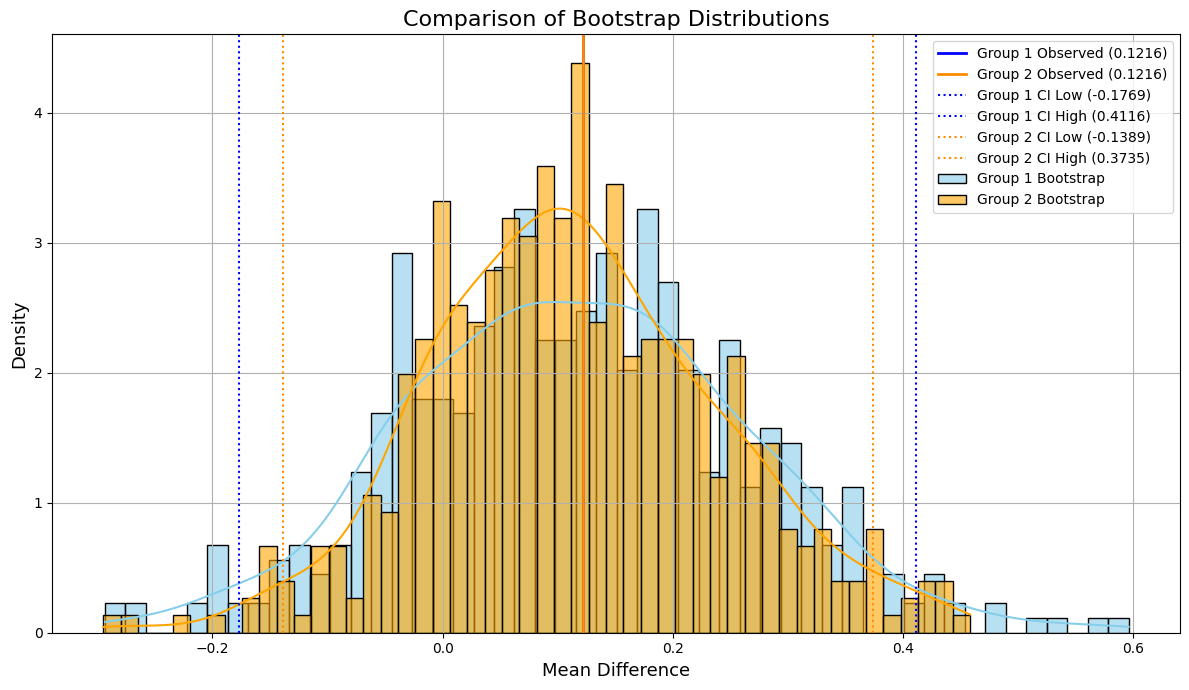

In [52]:
a = raw_cuped_cumm_df[raw_cuped_cumm_df['entity_id'] == 'DJ_CZ']

d = bootstrap_diff_means(a, 'analytical_profit_post')
f = bootstrap_diff_means(a, 'analytical_profit_post_cuped')

plot_bootstrap_comparison_differences_in_means(d, f)

In [51]:
raw_cuped_cumm_df.to_pickle(".holdout_data_latest_cuped.pkl")  

In [27]:
#cleaned_cumm_df['entity_id'].nunique()

55

In [38]:
rr = cleaned_cumm_df.groupby(['entity_id','is_customer_holdout']).agg({'customer_id':'nunique'}).reset_index()

rr.to_csv("customer_counts_by_entity.csv", index=False)


In [21]:
raw_cumm_df.isna().sum()

entity_id                         0
customer_id                       0
is_customer_holdout               0
orders_pre                 87378057
orders_post                87378057
analytical_profit_pre     116229941
analytical_profit_post     96377414
as_of_date                        0
dtype: int64

In [23]:
156146632 - 68194271

87952361

In [120]:
# store_data_cloud(raw_cuped_cumm_df, week_mondays)

In [119]:
# pre_post_metrics = [
#     ("analytical_profit_pre", "analytical_profit_post"),
#     ("orders_pre", "orders_post")
# ]

# apply_cuped_adjustment(a, entities, week_mondays, pre_post_metrics)

# print(result_df)

In [118]:
# result_df

In [117]:
# combined_data()

In [116]:
# bootstrap_single_group(
#     df: pd.DataFrame,
#     adjusted_metric: str,
#     n_resamples: int = 10000,
#     alpha: float = 0.05,
#     seed: int = 42
# ) -> dict:

#  plot_bootstrap_single_distribution(boot_result: dict, alpha: float = 0.05)

#  def plot_bootstrap_comparison_single_group(
#     result1: dict, label1: str,
#     result2: dict, label2: str,
#     alpha: float = 0.05
# ):


# def t_confidence_interval(data, alpha=0.05):

In [115]:
# raw_cuped_cumm_df['as_of_date'].unique()

In [114]:
# a = raw_cuped_cumm_df[(raw_cuped_cumm_df['as_of_date'] == '2025-04-14 00:00:00') & (raw_cuped_cumm_df['entity_id'] == 'FP_PK')]


In [113]:
# a['analytical_profit_post'].describe()

In [112]:
# tt  = bootstrap_single_group(
#    a,
#    "analytical_profit_post"
# )

In [111]:
# bb  = bootstrap_single_group(
#    a,
#    "analytical_profit_pre"
# )

In [110]:
# plot_bootstrap_single_distribution(tt)

In [109]:
# plot_bootstrap_single_distribution(bb)

In [108]:
# t_confidence_interval(data, alpha=0.05)

In [107]:
# tt

In [106]:
# t_confidence_interval(a['analytical_profit_post'].values, alpha=0.05)

In [105]:
# a

In [104]:
# d = bootstrap_diff_means(a, 'analytical_profit_post')

In [103]:
# f = bootstrap_diff_means(a, 'analytical_profit_post_cuped')

In [102]:
# plot_two_bootstrap_distributions(d, f)

In [101]:
# -0.0691 - 0.0886

In [100]:
# plot_bootstrap_distribution(f)

In [99]:
# plot_bootstrap_distribution(d)

In [98]:
# z = welchs_ttest_with_ci(a, 'analytical_profit_post')

In [97]:
# a

In [96]:
# apply_cuped_adjustment()


In [95]:
# from scipy.stats import norm


# # Your input values
# observed_diff = np.float64(0.005175359110324962)
# t_statistic = np.float64(0.13239070542770734)
# p_value = np.float64(0.8946757393529482)
# ci = (np.float64(-0.07144433735825026), np.float64(0.08179505557890018))
# alpha = 0.05

# # Estimate standard error from CI
# z = norm.ppf(1 - alpha / 2)
# se_diff = (ci[1] - observed_diff) / z

# # Plotting function
# def plot_ttest_distribution(observed_diff, se_diff, ci, alpha=0.05, n_points=1000):
#     x = np.linspace(observed_diff - 4*se_diff, observed_diff + 4*se_diff, n_points)
#     y = norm.pdf(x, loc=observed_diff, scale=se_diff)

#     plt.figure(figsize=(10, 6))
#     plt.plot(x, y, label="Sampling Distribution (Normal)", color='skyblue')

#     # Observed difference
#     plt.axvline(observed_diff, color='red', linestyle='-', label='Observed Mean Diff')
#     plt.text(observed_diff, max(y)*0.9, f"{observed_diff:.4f}", color='red', ha='center', va='bottom', fontsize=10)

#     # CI bounds
#     plt.axvline(ci[0], color='black', linestyle='--', label=f'{100*(1-alpha):.0f}% CI')
#     plt.axvline(ci[1], color='black', linestyle='--')
#     plt.text(ci[0], max(y)*0.6, f"{ci[0]:.4f}", color='black', ha='right', va='bottom', fontsize=10)
#     plt.text(ci[1], max(y)*0.6, f"{ci[1]:.4f}", color='black', ha='left', va='bottom', fontsize=10)

#     # Labels and formatting
#     plt.title("Sampling Distribution of Mean Difference (Welch’s t-test)")
#     plt.xlabel("Mean Difference")
#     plt.ylabel("Density")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Call the function with computed se_diff
# plot_ttest_distribution(observed_diff, se_diff, ci, alpha)

In [94]:
# plot_ttest_distribution(0.005175359110324962, se_diff, ci, alpha=0.05, n_points=1000):

In [93]:
# a = raw_cuped_cumm_df[raw_cuped_cumm_df['entity_id'] == "FP_PK"]

In [92]:
# raw_cuped_cumm_df

In [91]:
# import matplotlib.pyplot as plt

# results = bootstrap_diff_means(a, "orders_post_cuped")

# # Convert % for plotting
# for r in results:
#     r["mean_pct"] = r["bootstrap_mean_diff"] * 100
#     r["ci_low"] = r["ci"]["diff"][0] * 100
#     r["ci_high"] = r["ci"]["diff"][1] * 100

# # Plot
# fig, ax = plt.subplots(figsize=(9, 3))

# for i, r in enumerate(results):
#     ax.errorbar(r["mean_pct"], i, xerr=[[r["mean_pct"] - r["ci_low"]], [r["ci_high"] - r["mean_pct"]]],
#                 fmt='o', capsize=5, capthick=2, label=r["label"])

#     # Optional: background bar
#     ax.axhspan(i - 0.3, i + 0.3, color='gray', alpha=0.05)

# # Formatting
# ax.axvline(0, color='gray', linestyle='--')
# ax.set_yticks(range(len(results)))
# ax.set_yticklabels([r["label"] for r in results])
# ax.set_xlabel("Uplift (percentage points)")
# ax.set_title("Bootstrapped Differences in Means")
# plt.grid(True, axis='x', linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

In [90]:
# CI_comparison_single(raw_cuped_cumm_df, "orders_post_cuped","PY_DO", holdout = True)

In [89]:
# CI_comparison_differences(raw_cuped_cumm_df, "orders_post_cuped","PY_DO")

In [88]:
# a = raw_cuped_cumm_df[(raw_cuped_cumm_df["is_customer_holdout"] == True) & (raw_cuped_cumm_df["entity_id"] == "PY_DO")]

In [21]:
# a

,entity_id,customer_id,is_customer_holdout,orders_pre,orders_post,analytical_profit_pre,analytical_profit_post,as_of_date,analytical_profit_post_cuped,orders_post_cuped
50356,PY_DO,16496517,True,11,27,42.628823,90.977305,2025-03-31,52.081002,19.122292
50357,PY_DO,78054397,True,0,1,0.000000,2.754215,2025-03-31,9.396003,5.024267
50358,PY_DO,84376670,True,7,15,25.782875,14.553229,2025-03-31,-6.347449,11.450283
50359,PY_DO,59379790,True,2,3,0.251678,0.636564,2025-03-31,7.009498,4.860272
50360,PY_DO,67657819,True,11,7,34.286351,22.118214,2025-03-31,-7.866272,-0.877708
...,...,...,...,...,...,...,...,...,...,...
61790,PY_DO,20815034,True,0,4,0.000000,5.438421,2025-03-31,12.080209,8.024267
61791,PY_DO,16499131,True,15,18,39.712943,72.608401,2025-03-31,36.826977,5.794301
61792,PY_DO,89269107,True,0,5,0.000000,2.307820,2025-03-31,8.949608,9.024267
61793,PY_DO,41086030,True,3,0,3.558943,0.000000,2025-03-31,2.839960,0.778274


In [87]:
# raw_cuped_cumm_df = apply_cuped_adjustment(cleaned_cumm_df, entities, week_mondays)

In [85]:
# raw_cuped_cumm_df.isna().sum()

In [84]:
# holdout = raw_cuped_cumm_df[(raw_cuped_cumm_df['is_customer_holdout'] == True) & (raw_cuped_cumm_df['entity_id'] == 'PY_DO')]
# non_holdout = raw_cuped_cumm_df[(raw_cuped_cumm_df['is_customer_holdout'] == False) & (raw_cuped_cumm_df['entity_id'] == 'PY_DO')]

In [86]:
# a = bootstrap_single_group(non_holdout, "analytical_profit_post_cuped")
# b = bootstrap_single_group(non_holdout, "analytical_profit_post")

# plot_bootstrap_comparison(a, "Post-CUPED", b, "Post-Raw")

In [81]:
# a = t_confidence_interval(h["analytical_profit_post_cuped"])
# b = t_confidence_interval(h["analytical_profit_post"])

In [82]:
# a

In [83]:
# b

In [80]:
# hb_cuped = bootstrap_single_group(h,"")
# hb_non_cuped = bootstrap_single_group(nh)

In [79]:
# from sklearn.linear_model import Ridge

# X = holdout[['analytical_profit_pre']]
# y = holdout['analytical_profit_post']

# ridge = Ridge(alpha=1.0)
# ridge.fit(X, y)

# theta_ridge = ridge.coef_[0]

# holdout["cuped_ridge"] = (
#     holdout['analytical_profit_post'] - theta_ridge * (holdout['analytical_profit_pre'] - holdout['analytical_profit_pre'].mean())
# )

# print(holdout['cuped_ridge'].mean())

# print("Original variance:", holdout['cuped_standard'].var())
# print("CUPED variance:   ", holdout['cuped_ridge'].var())

# X = non_holdout[['analytical_profit_pre']]
# y = non_holdout['analytical_profit_post']

# ridge = Ridge(alpha=1.0)
# ridge.fit(X, y)

# theta_ridge = ridge.coef_[0]

# non_holdout["cuped_ridge"] = (
#     non_holdout['analytical_profit_post'] - theta_ridge * (non_holdout['analytical_profit_pre'] - non_holdout['analytical_profit_pre'].mean())
# )

# print(non_holdout['cuped_ridge'].mean())

# print("Original variance:", non_holdout['cuped_standard'].var())
# print("CUPED variance:   ", non_holdout['cuped_ridge'].var())



In [78]:
# group_a = test[test["is_customer_holdout"] == False]
# group_b = test[test["is_customer_holdout"] == True]

In [77]:
# a = bootstrap_single_group(
#     group_a,
#     "orders_post"
# )

# b = bootstrap_single_group(
#     group_b,
#     "orders_post"
# )

In [76]:
# a = bootstrap_with_pvalue(test, "orders_post")

In [75]:
# from scipy.stats import norm

# result_ttest = welchs_ttest_with_ci(test, "orders_post")

# # Recalculate standard error using same logic as in your function
# group_a = test[test["is_customer_holdout"] == False]["orders_post"].values
# group_b = test[test["is_customer_holdout"] == True]["orders_post"].values

# se_diff = np.sqrt(np.var(group_a, ddof=1) / len(group_a) + np.var(group_b, ddof=1) / len(group_b))

# # Now plot
# plot_ttest_distribution(
#     observed_diff=result_ttest["observed_diff"],
#     se_diff=se_diff,
#     ci=result_ttest["ci"],
#     alpha=0.05
# )


In [74]:
# plot_bootstrap_distribution(a)


In [73]:
# cleaned_cumm_df[(cleaned_cumm_df['entity_id'] == 'PY_DO') & (cleaned_cumm_df['entity_id'] == 'PY_DO')]

In [72]:
# # Example: conversion rates in two groups
# a = cleaned_cumm_df[(cleaned_cumm_df['entity_id'] == 'PY_DO') & (cleaned_cumm_df['is_customer_holdout'] == True)]['orders_post']
# b = cleaned_cumm_df[(cleaned_cumm_df['entity_id'] == 'PY_DO') & (cleaned_cumm_df['is_customer_holdout'] == False)]['orders_post']

# result = bootstrap_ttest(a, b)

# print(f"Observed diff: {result['observed_diff']:.4f}")
# print(f"P-value: {result['p_value']:.4f}")
# print(f"95% CI: {result['ci']}")

In [71]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.histplot(result["boot_diffs"], bins=50, kde=True)
# plt.axvline(result["observed_diff"], color='red', linestyle='--', label='Observed Diff')
# plt.title("Bootstrapped Distribution of Difference in Means")
# plt.xlabel("Difference in Means")
# plt.legend()
# plt.show()

In [88]:
# ## Define the list of entities that have data in marketing tables ## 
# ## --> rest of the data is extracted from DPS with condition not in the following entities ##

# # mkt_entity_id = tuple(set((
# #     'FP_PK','PY_DO','PY_BO', 'FP_TW', 
# #     'PY_PY', 'DJ_CZ', 'PY_EC','MJM_AT' ,'PY_PE', 'PY_AR',
# #     'PY_GT','PY_SV' ,'FP_PH','PY_NI' ,'NP_HU' ,'FP_MM','EF_GR',
# #     'AP_PA','YS_TR', 'PY_UY' ,'OP_SE' ,'PY_CL' ,'FP_BD' ,'FP_SG',
# #     'FO_NO' ,'PY_CR', 'FP_LA','PY_HN', 'FP_MY' ,'FP_TH', 'FY_CY',
# #     'PY_VE','PO_FI','TB_QA','TB_OM','TB_KW','TB_JO','TB_IQ',
# #     'TB_BH','TB_AE','HS_SA'
# # )))

# mkt_entity_id = (
#     'FP_PK','PY_DO'
# )


# client = initialize_bigquery_client(project)

# final_df = pd.DataFrame()  # Empty DataFrame to store the results

# for m in week_mondays:
#     print(f"Querying for week starting {m}")
    
#     # Run your query
#     test = client.query(marketing_data(mkt_entity_id, m)).to_dataframe()

#     # Add the as_of_date column
#     test["as_of_date"] = m

#     # Append to the final dataframe
#     final_df = pd.concat([final_df, test], ignore_index=True)

In [89]:
# get_cumm_data(project, mkt_entity_id, week_mondays)

In [70]:
# week_mondays

In [70]:
# extract_data(project, get_marketing_data(mkt_entity_id, '2025-02-03'), get_dps_data(mkt_entity_id, '2025-02-03'))

In [71]:
# a = fill_nans(final_df)

In [72]:
# b = drop_users_with_no_data(a)

In [73]:
# b

In [74]:
# c = b[b['as_of_date'] == date(2025, 2, 3)]


In [75]:
# d = c[c['entity_id'] == 'FP_PK']

In [76]:
# d.describe()

In [69]:
# d[d['orders_pre'] < ]['orders_pre'].hist()

In [67]:
# d[d['orders_post'] > 100]

In [68]:
# df = drop_users_with_no_data(raw_data)